위에서 아래로 봤을때 어떻게 분포되었는지 보려고 한다.
이것을 통해서 이미지의 중심이나 대략적 위치를 파악할 수 있다.

In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import rescale_img_to_hu

In [2]:
# DATA_DIR = "../../dataset/"
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
SEG_DIR = os.path.join(DATA_DIR, "segmentations")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train_df_with_slices.csv"))

In [3]:
train_df["StudyInstanceUID"][:10]

0     1.2.826.0.1.3680043.6200
1    1.2.826.0.1.3680043.27262
2    1.2.826.0.1.3680043.21561
3    1.2.826.0.1.3680043.12351
4     1.2.826.0.1.3680043.1363
5     1.2.826.0.1.3680043.4859
6    1.2.826.0.1.3680043.18659
7    1.2.826.0.1.3680043.17364
8      1.2.826.0.1.3680043.849
9    1.2.826.0.1.3680043.24045
Name: StudyInstanceUID, dtype: object

In [4]:
train_df[train_df["StudyInstanceUID"] == "1.2.826.0.1.3680043.4859"].num_slices.values[0]

310

In [22]:
def read_patient_dcm(train_df, train_image_dir, patient_id):
    num_slices = train_df.loc[train_df["StudyInstanceUID"] == patient_id].num_slices.values[0]
    print(f"Number of slices for patient : {num_slices} in {patient_id}")

    patient_dir = os.path.join(train_image_dir, patient_id)

    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    for i in range(num_slices):
        ds = pydicom.dcmread(os.path.join(patient_dir, f"{i+1}.dcm"))

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    return imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses


# result = read_patient_dcm(train_df, TRAIN_IMAGE_DIR, "1.2.826.0.1.3680043.4859")
# result[0].shape

In [30]:
imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses = read_patient_dcm(train_df, TRAIN_IMAGE_DIR, "1.2.826.0.1.3680043.4859")

np.save('imgs-4859', imgs)
#
# plt.imshow(np.mean(np.clip(imgs, a_min=0, a_max=2242), axis=0), cmap='bone')
# plt.show()

Number of slices for patient : 310 1.2.826.0.1.3680043.4859


In [32]:
np.savez_compressed('imgs-4859-compressed', imgs)

In [31]:
imgs.shape

(310, 512, 512)

## axial views

Number of slices for patient: 243
Number of slices for patient: 406
Number of slices for patient: 385
Number of slices for patient: 501
Number of slices for patient: 199
Number of slices for patient: 310
Number of slices for patient: 328
Number of slices for patient: 297
Number of slices for patient: 571
Number of slices for patient: 563


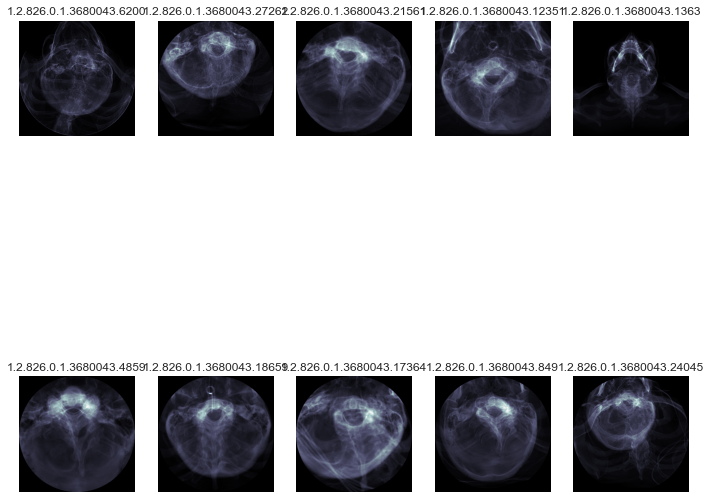

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(12, 12))

for i in range(10):
    patient_id = train_df.iloc[i]["StudyInstanceUID"]
    imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses = read_patient_dcm(train_df, TRAIN_IMAGE_DIR, patient_id)
    axs[i // 5, i % 5].imshow(np.mean(np.clip(imgs, a_min=0, a_max=2242), axis=0), cmap='bone')
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(patient_id)
plt.show()

## sagittal

Number of slices for patient : 243 1.2.826.0.1.3680043.6200
Number of slices for patient : 406 1.2.826.0.1.3680043.27262
Number of slices for patient : 385 1.2.826.0.1.3680043.21561
Number of slices for patient : 501 1.2.826.0.1.3680043.12351
Number of slices for patient : 199 1.2.826.0.1.3680043.1363
Number of slices for patient : 310 1.2.826.0.1.3680043.4859
Number of slices for patient : 328 1.2.826.0.1.3680043.18659
Number of slices for patient : 297 1.2.826.0.1.3680043.17364
Number of slices for patient : 571 1.2.826.0.1.3680043.849
Number of slices for patient : 563 1.2.826.0.1.3680043.24045


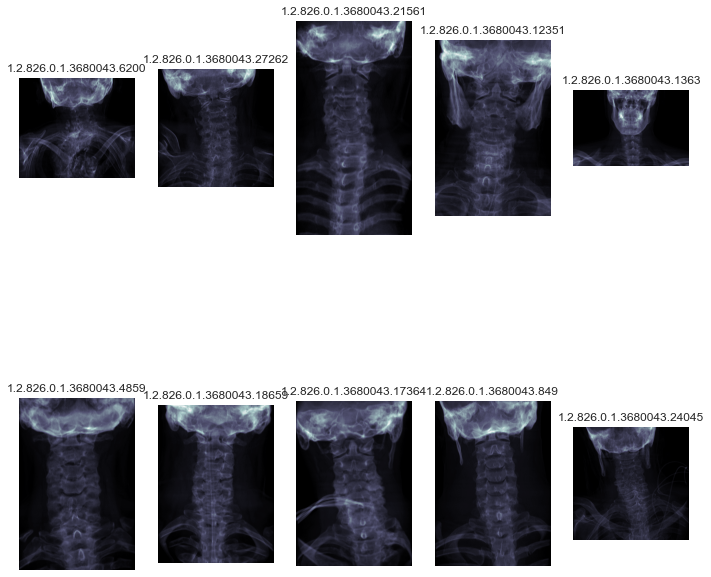

In [28]:
fig, axs = plt.subplots(2, 5, figsize=(12, 12))

for i in range(10):
    patient_id = train_df.iloc[i]["StudyInstanceUID"]
    imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses = read_patient_dcm(train_df, TRAIN_IMAGE_DIR, patient_id)
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing # 이게 반복해야 되는 수치다
    axs[i // 5, i % 5].imshow(np.mean(np.clip(imgs, a_min=0, a_max=2242), axis=1), cmap='bone')
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_aspect(aspect)
    axs[i // 5, i % 5].set_title(patient_id)
plt.show()

## coronal

Number of slices for patient : 243 1.2.826.0.1.3680043.6200
Number of slices for patient : 406 1.2.826.0.1.3680043.27262
Number of slices for patient : 385 1.2.826.0.1.3680043.21561
Number of slices for patient : 501 1.2.826.0.1.3680043.12351
Number of slices for patient : 199 1.2.826.0.1.3680043.1363
Number of slices for patient : 310 1.2.826.0.1.3680043.4859
Number of slices for patient : 328 1.2.826.0.1.3680043.18659
Number of slices for patient : 297 1.2.826.0.1.3680043.17364
Number of slices for patient : 571 1.2.826.0.1.3680043.849
Number of slices for patient : 563 1.2.826.0.1.3680043.24045


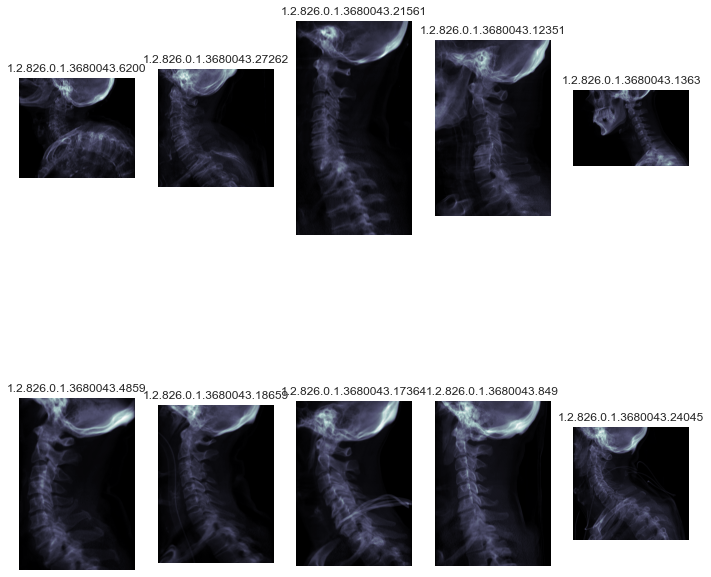

In [29]:
fig, axs = plt.subplots(2, 5, figsize=(12, 12))

for i in range(10):
    patient_id = train_df.iloc[i]["StudyInstanceUID"]
    imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses = read_patient_dcm(train_df, TRAIN_IMAGE_DIR, patient_id)
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    axs[i // 5, i % 5].imshow(np.mean(np.clip(imgs, a_min=0, a_max=2242), axis=2), cmap='bone')
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_aspect(aspect)
    axs[i // 5, i % 5].set_title(patient_id)
plt.show()